In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

In [2]:
EXAMPLES_PER_CLASS = 100
USELESS_FEATURES = 1

train_data = []
train_labels = []

for _ in range(EXAMPLES_PER_CLASS):
    train_data.append([0., 0., np.random.random()])
    train_labels.append(0)

    train_data.append([0., 1., np.random.random()])
    train_labels.append(1)

    train_data.append([1., 0., np.random.random()])
    train_labels.append(1)

    train_data.append([1., 1., np.random.random()])
    train_labels.append(0)

train_data, train_labels = torch.tensor(train_data), torch.tensor(train_labels)

test_data = []
test_labels = []

for _ in range(EXAMPLES_PER_CLASS//5):
    test_data.append([0., 0., np.random.random()])
    test_labels.append(0.)

    test_data.append([0., 1., np.random.random()])
    test_labels.append(1.)

    test_data.append([1., 0., np.random.random()])
    test_labels.append(1.)

    test_data.append([1., 1., np.random.random()])
    test_labels.append(0.)

test_data, test_labels = torch.tensor(test_data), torch.tensor(test_labels)

In [3]:
torch.manual_seed(0)
hidden = 10
model = nn.Sequential(
    nn.Linear(2+USELESS_FEATURES, hidden),
    nn.ReLU(),
    nn.Linear(hidden, 2)
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_pred) * 100

In [4]:
epochs = 1000
for epoch in range(epochs):
    y_logits = model(train_data).squeeze()
    y_preds = torch.argmax(y_logits, dim=1)
    
    loss = loss_fn(y_logits, train_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    if epoch % (epochs//10) == 0:
        with torch.inference_mode():
            y_logits = model(test_data).squeeze()
            y_preds = torch.argmax(y_logits, dim=1)
            acc = accuracy_fn(test_labels, y_preds)
            print(f"[EPOCH {epoch+1}/{epochs}] Loss: {loss} | Accuracy: {acc}")

[EPOCH 1/1000] Loss: 0.7112053632736206 | Accuracy: 50.0
[EPOCH 101/1000] Loss: 0.6114341616630554 | Accuracy: 92.5
[EPOCH 201/1000] Loss: 0.46416449546813965 | Accuracy: 75.0
[EPOCH 301/1000] Loss: 0.29790982604026794 | Accuracy: 100.0
[EPOCH 401/1000] Loss: 0.1504603922367096 | Accuracy: 100.0
[EPOCH 501/1000] Loss: 0.08022993057966232 | Accuracy: 100.0
[EPOCH 601/1000] Loss: 0.04904595762491226 | Accuracy: 100.0
[EPOCH 701/1000] Loss: 0.033435408025979996 | Accuracy: 100.0
[EPOCH 801/1000] Loss: 0.02461276948451996 | Accuracy: 100.0
[EPOCH 901/1000] Loss: 0.01907242462038994 | Accuracy: 100.0


(-0.10000000149011612, 1.100000023841858)

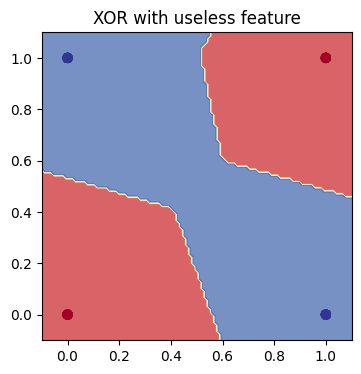

In [5]:
plt.figure(figsize=(4, 4))
plt.title("XOR with useless feature")

x_min, x_max = test_data[:, 0].min() - 0.1, test_data[:, 0].max() + 0.1
y_min, y_max = test_data[:, 1].min() - 0.1, test_data[:, 1].max() + 0.1
z_min, z_max = test_data[:, 2].min() - 0.1, test_data[:, 2].max() + 0.1
xx, yy, zz = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101), np.linspace(z_min, z_max, 101))

# Make features
X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel(), zz.ravel()))).float()

# Make predictions
model.eval()
with torch.inference_mode():
    y_logits = model(X_to_pred_on)

# Test for multi-class or binary and adjust logits to prediction labels
y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class

# Reshape preds and plot
y_pred = y_pred.reshape(xx.shape).detach().numpy()
plt.contourf(xx[:,:,0], yy[:,:,0], y_pred[:,:,0], cmap=plt.cm.RdYlBu, alpha=0.7)
plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, s=40, cmap=plt.cm.RdYlBu)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [6]:
X = test_data.detach().numpy()
T = test_labels.detach().numpy()

In [7]:
# Extract weights and biases of trained MLP
layers = list(filter(None, [layer if isinstance(layer, nn.Linear) else None for layer in model.children()]))
W = [layer.weight.to('cpu').detach().numpy().T for layer in layers]
B = [layer.bias.to('cpu').detach().numpy().T for layer in layers]
L = len(W)
L, W[0].shape, W[1].shape

(2, (3, 10), (10, 2))

In [8]:
# Forward pass
A = [X] + [None] * L
for l in range(L):
    A[l+1] = np.maximum(0, A[l].dot(W[l])+B[l])

In [9]:
i = np.random.randint(0, len(X))
prediction = np.argmax(A[L][i])
print(f"Point: {X[i]}, Pred: {prediction} | Label: {T[i]}")

Point: [1.        0.        0.5438533], Pred: 1 | Label: 1.0


In [10]:
nb_labels = len(np.unique(T))
R = [None] * L + [A[L] * (T[:,None]==np.arange(nb_labels))]
#R = [None] * L + [A[L]]

In [11]:
def rho(w, l):  
    return w + [None,0.1,0.0][l] * np.maximum(0,w)
def incr(z, l):
    return z + [None,0.1,0.0][l] * (z**2).mean()**.5+1e-9

In [12]:
# All layers except the pixels one
for l in range(1, L)[::-1]:
    w = rho(W[l], l)
    b = rho(B[l], l)

    z = incr(A[l].dot(w)+b, l)
    s = R[l+1] / z
    c = s.dot(w.T)
    R[l] = A[l] * c

In [13]:
w = W[0]
wp = np.maximum(0, w)
wm = np.minimum(0, w)
lb = A[0]*0#-1
hb = A[0]*0+1

z = A[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9
s = R[1]/z
c, cp, cm = s.dot(w.T), s.dot(wp.T), s.dot(wm.T)
R[0] = A[0]*c - lb*cp - hb*cm

In [14]:
R[0].shape, R[1].shape, R[2].shape

((80, 3), (80, 10), (80, 2))

In [15]:
for i in range(8):
    print(f"P: {X[i].tolist()} | Label: {X[i]} | Relevance: {R[0][i]}")

P: [0.0, 0.0, 0.7729982137680054] | Label: [0.        0.        0.7729982] | Relevance: [ 1.8235369  -0.03334607  0.21538346]
P: [0.0, 1.0, 0.9142534136772156] | Label: [0.        1.        0.9142534] | Relevance: [ 1.6546916   0.44240642 -0.05926798]
P: [1.0, 0.0, 0.5438532829284668] | Label: [1.        0.        0.5438533] | Relevance: [-0.87733376  2.7018347  -0.02103375]
P: [1.0, 1.0, 0.061705440282821655] | Label: [1.         1.         0.06170544] | Relevance: [0.8309903 0.9020534 0.026085 ]
P: [0.0, 0.0, 0.1165616437792778] | Label: [0.         0.         0.11656164] | Relevance: [ 1.876317   -0.02716843  0.31629935]
P: [0.0, 1.0, 0.7498367428779602] | Label: [0.         1.         0.74983674] | Relevance: [ 1.6561      0.43484473 -0.05203488]
P: [1.0, 0.0, 0.4676847755908966] | Label: [1.         0.         0.46768478] | Relevance: [-0.88632256  2.7030141  -0.0202215 ]
P: [1.0, 1.0, 0.9294699430465698] | Label: [1.         1.         0.92946994] | Relevance: [ 0.77190226  0.833

    [Layer 0] [ 1.8235369  -0.03334607  0.21538346]
    [Layer 1] [-0.0000000e+00 -2.5726557e+00 -6.7062589e-04 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00  0.0000000e+00  5.5406606e-01
 -1.9317025e-01  4.2180042e+00]
    [Layer 2] [2.2249732 0.       ]


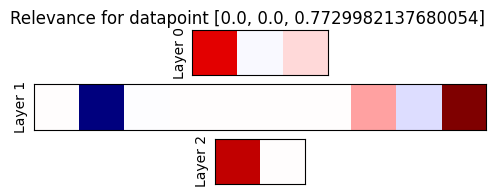

    [Layer 0] [ 1.8235369  -0.03334607  0.21538346]
    [Layer 1] [-0.0000000e+00 -2.5726557e+00 -6.7062589e-04 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00  0.0000000e+00  5.5406606e-01
 -1.9317025e-01  4.2180042e+00]
    [Layer 2] [2.2249732 0.       ]


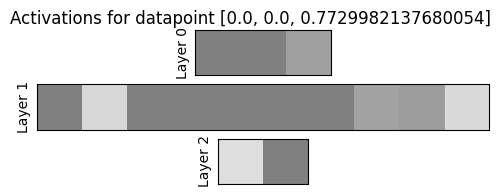

    [Layer 0] [ 1.6546916   0.44240642 -0.05926798]
    [Layer 1] [ 0.          0.63225186  2.7288563   0.          0.         -0.03465049
  0.         -1.2984285   0.00980084 -0.        ]
    [Layer 2] [0.       2.391336]


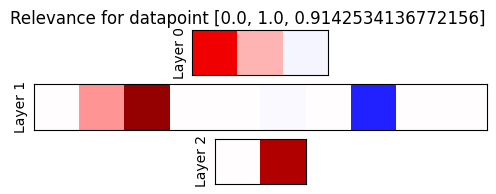

    [Layer 0] [ 1.6546916   0.44240642 -0.05926798]
    [Layer 1] [ 0.          0.63225186  2.7288563   0.          0.         -0.03465049
  0.         -1.2984285   0.00980084 -0.        ]
    [Layer 2] [0.       2.391336]


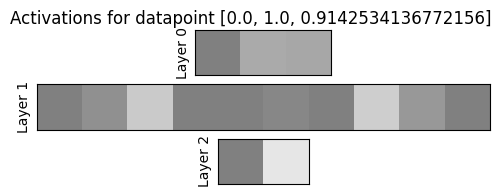

    [Layer 0] [-0.87733376  2.7018347  -0.02103375]
    [Layer 1] [ 0.          2.9192305   0.          0.          0.         -0.
  0.         -1.1226525   0.00688912 -0.        ]
    [Layer 2] [0.        2.1553013]


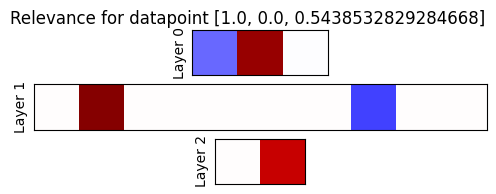

    [Layer 0] [-0.87733376  2.7018347  -0.02103375]
    [Layer 1] [ 0.          2.9192305   0.          0.          0.         -0.
  0.         -1.1226525   0.00688912 -0.        ]
    [Layer 2] [0.        2.1553013]


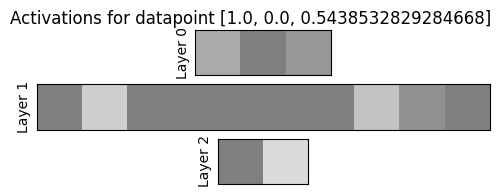

    [Layer 0] [0.8309903 0.9020534 0.026085 ]
    [Layer 1] [-5.1653478e-04 -0.0000000e+00 -7.5540849e-04 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00  0.0000000e+00  1.7604007e+00
 -0.0000000e+00  0.0000000e+00]
    [Layer 2] [2.0073967 0.       ]


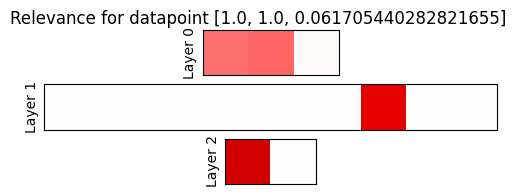

    [Layer 0] [0.8309903 0.9020534 0.026085 ]
    [Layer 1] [-5.1653478e-04 -0.0000000e+00 -7.5540849e-04 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00  0.0000000e+00  1.7604007e+00
 -0.0000000e+00  0.0000000e+00]
    [Layer 2] [2.0073967 0.       ]


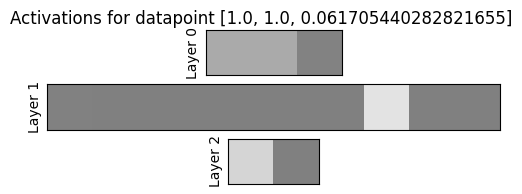

    [Layer 0] [ 1.876317   -0.02716843  0.31629935]
    [Layer 1] [-0.0000000e+00 -2.4268050e+00 -7.4377039e-04 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00  0.0000000e+00  3.6734825e-01
 -1.0247052e-01  4.3281188e+00]
    [Layer 2] [2.3908048 0.       ]


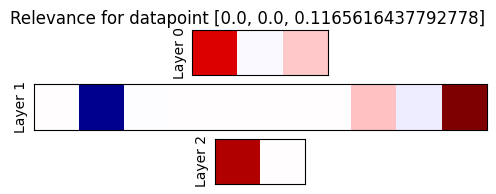

    [Layer 0] [ 1.876317   -0.02716843  0.31629935]
    [Layer 1] [-0.0000000e+00 -2.4268050e+00 -7.4377039e-04 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00  0.0000000e+00  3.6734825e-01
 -1.0247052e-01  4.3281188e+00]
    [Layer 2] [2.3908048 0.       ]


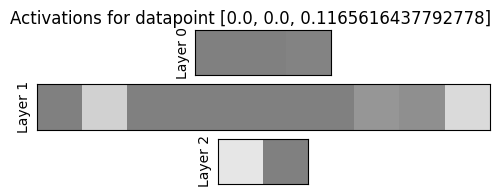

    [Layer 0] [ 1.6561      0.43484473 -0.05203488]
    [Layer 1] [ 0.          0.56544995  2.736633    0.          0.         -0.0215544
  0.         -1.2499859   0.00836725 -0.        ]
    [Layer 2] [0.       2.393421]


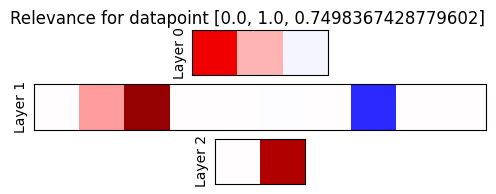

    [Layer 0] [ 1.6561      0.43484473 -0.05203488]
    [Layer 1] [ 0.          0.56544995  2.736633    0.          0.         -0.0215544
  0.         -1.2499859   0.00836725 -0.        ]
    [Layer 2] [0.       2.393421]


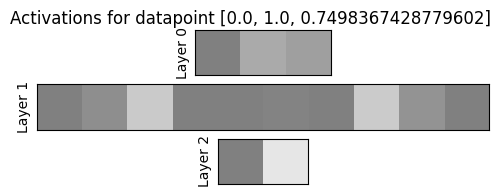

    [Layer 0] [-0.88632256  2.7030141  -0.0202215 ]
    [Layer 1] [ 0.         2.8896935  0.         0.         0.        -0.
  0.        -1.0994449  0.0062215 -0.       ]
    [Layer 2] [0.        2.1485488]


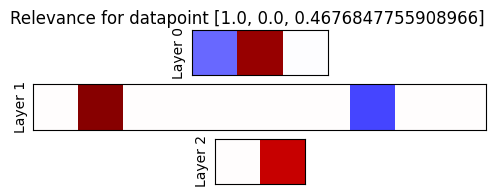

    [Layer 0] [-0.88632256  2.7030141  -0.0202215 ]
    [Layer 1] [ 0.         2.8896935  0.         0.         0.        -0.
  0.        -1.0994449  0.0062215 -0.       ]
    [Layer 2] [0.        2.1485488]


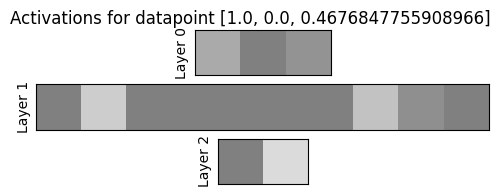

    [Layer 0] [ 0.77190226  0.8339292  -0.03041429]
    [Layer 1] [-0.00000000e+00 -2.70567417e-01 -6.53699448e-04 -0.00000000e+00
 -0.00000000e+00 -2.10267007e-02  0.00000000e+00  1.98821461e+00
 -1.20549515e-01  0.00000000e+00]
    [Layer 2] [1.8157066 0.       ]


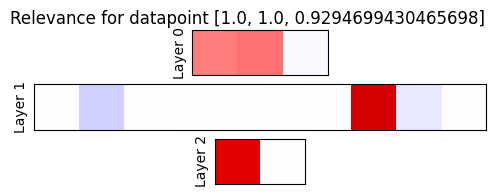

    [Layer 0] [ 0.77190226  0.8339292  -0.03041429]
    [Layer 1] [-0.00000000e+00 -2.70567417e-01 -6.53699448e-04 -0.00000000e+00
 -0.00000000e+00 -2.10267007e-02  0.00000000e+00  1.98821461e+00
 -1.20549515e-01  0.00000000e+00]
    [Layer 2] [1.8157066 0.       ]


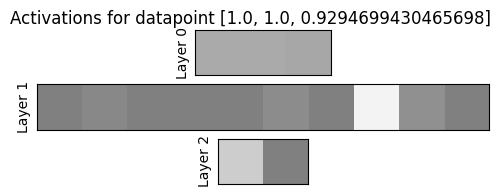

In [16]:
cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
cmap = ListedColormap(cmap)

for i in range(8):
    #print(f"[POINT] {data[i].tolist()}")

    # -- Display relevance --
    fig, axs = plt.subplots(L+1, 1)
    b = 3
    for l in range(L+1):
        axs[l].imshow(R[l][i].reshape((1, len(R[l][i]))), cmap=cmap, interpolation='nearest', vmin=-b,vmax=b)
        axs[l].figure.set_size_inches(10, 2)
        print(f"    [Layer {l}] {R[l][i]}")
        axs[l].set_xticks([])
        axs[l].set_yticks([])
        axs[l].set_ylabel(f"Layer {l}")

    fig.suptitle(f"Relevance for datapoint {X[i].tolist()}")
    plt.show()

    # -- Display activations --
    fig, axs = plt.subplots(L+1, 1)
    b = 3
    for l in range(L+1):
        axs[l].imshow(A[l][i].reshape((1, len(A[l][i]))), cmap="gray", interpolation='nearest', vmin=-b,vmax=b)
        axs[l].figure.set_size_inches(10, 2)
        print(f"    [Layer {l}] {R[l][i]}")
        axs[l].set_xticks([])
        axs[l].set_yticks([])
        axs[l].set_ylabel(f"Layer {l}")

    fig.suptitle(f"Activations for datapoint {X[i].tolist()}")
    plt.show()

### Average relevance
#### Entire dataset

    [Layer 0] R: [0.85299647 0.9894621  0.05550689]
    [Layer 1] R: [ 0.00150714  0.180502    0.68583584  0.          0.         -0.00614905
  0.          0.01721564 -0.05009485  1.0691485 ]
    [Layer 2] R: [1.0561572 1.1353778]


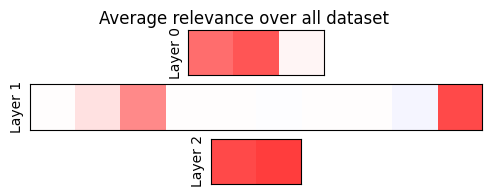

    [Layer 0] A: [0.5        0.5        0.50327384]
    [Layer 1] A: [0.00819113 1.0533317  0.4386724  0.         0.         0.05696553
 0.         1.6138494  0.37085885 0.53236544]
    [Layer 2] A: [1.0561572 1.1353778]


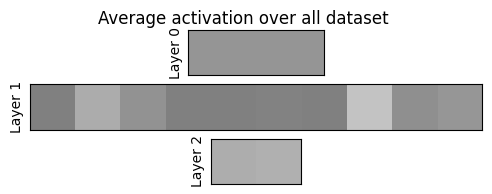

In [17]:
cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
cmap = ListedColormap(cmap)

# -- Display relevance --
fig, axs = plt.subplots(L+1, 1)
b = 3
for l in range(L+1):
    relevance = np.mean(R[l], axis=0)

    axs[l].imshow(relevance.reshape((1, len(relevance))), cmap=cmap, interpolation='nearest', vmin=-b,vmax=b)
    axs[l].figure.set_size_inches(10, 2)
    print(f"    [Layer {l}] R: {relevance}")
    axs[l].set_xticks([])
    axs[l].set_yticks([])
    axs[l].set_ylabel(f"Layer {l}")

fig.suptitle(f"Average relevance over all dataset")
plt.show()

# -- Display activations --
fig, axs = plt.subplots(L+1, 1)
b = 3
for l in range(L+1):
    activation = np.mean(A[l], axis=0)

    axs[l].imshow(activation.reshape((1, len(activation))), cmap="gray", interpolation='nearest', vmin=-b,vmax=b)
    axs[l].figure.set_size_inches(10, 2)
    print(f"    [Layer {l}] A: {activation}")
    axs[l].set_xticks([])
    axs[l].set_yticks([])
    axs[l].set_ylabel(f"Layer {l}")

fig.suptitle(f"Average activation over all dataset")
plt.show()

#### Grouped by class

    [Layer 0] R: [ 1.8514467  -0.03029167  0.26894024]
    [Layer 1] R: [ 0.0000000e+00 -2.4961646e+00 -7.0926093e-04  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  4.5575839e-01
 -1.4540586e-01  4.2766161e+00]
    [Layer 2] R: [2.3126645 0.       ]


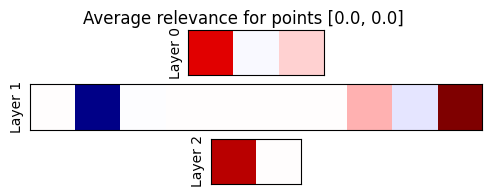

    [Layer 0] A: [0.         0.         0.42587584]
    [Layer 1] A: [0.0000000e+00 1.9953511e+00 5.9543253e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 6.7235774e-01 5.2013743e-01 2.1294513e+00]
    [Layer 2] A: [2.3126645 0.       ]


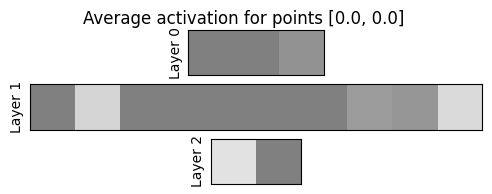

    [Layer 0] R: [ 1.6551228   0.4223079  -0.03851881]
    [Layer 1] R: [ 6.0865437e-03  4.8712277e-01  2.7447493e+00  0.0000000e+00
  0.0000000e+00 -1.2827523e-02  0.0000000e+00 -1.1928854e+00
  6.6876761e-03 -2.1702264e-05]
    [Layer 2] R: [0.        2.3944716]


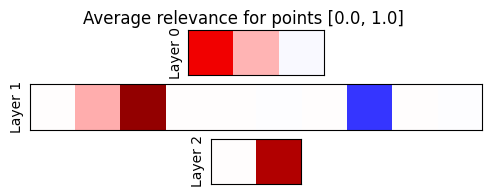

    [Layer 0] A: [0.        1.        0.5598237]
    [Layer 1] A: [2.9071813e-02 3.0216649e-01 1.7535610e+00 0.0000000e+00 0.0000000e+00
 6.2130678e-02 0.0000000e+00 1.6768070e+00 3.8676682e-01 1.0395050e-05]
    [Layer 2] A: [0.        2.3944716]


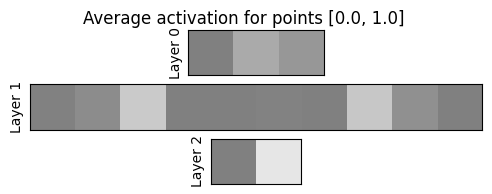

    [Layer 0] R: [-0.8913886   2.703214   -0.01692894]
    [Layer 1] R: [ 0.          2.8829398   0.          0.          0.          0.
  0.         -1.0941111   0.00606746  0.        ]
    [Layer 2] R: [0.        2.1470394]


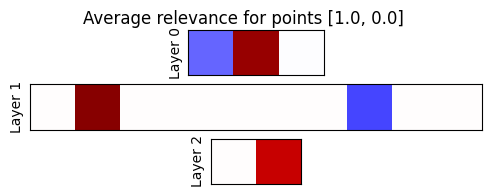

    [Layer 0] A: [1.         0.         0.45065933]
    [Layer 1] A: [0.        1.8040075 0.        0.        0.        0.        0.
 1.55265   0.3540382 0.       ]
    [Layer 2] A: [0.        2.1470394]


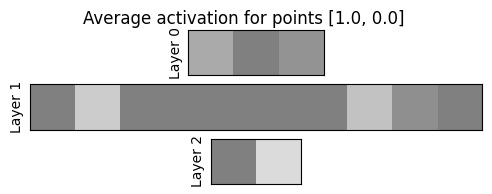

    [Layer 0] R: [0.7968047  0.8626188  0.00853504]
    [Layer 1] R: [-5.8001908e-05 -1.5189028e-01 -6.9617265e-04  0.0000000e+00
  0.0000000e+00 -1.1768688e-02  0.0000000e+00  1.9001004e+00
 -6.7728698e-02  0.0000000e+00]
    [Layer 2] R: [1.9119647 0.       ]


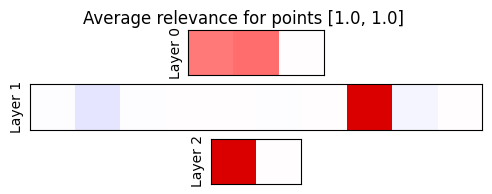

    [Layer 0] A: [1.        1.        0.5767375]
    [Layer 1] A: [3.6927275e-03 1.1180167e-01 5.3298566e-04 0.0000000e+00 0.0000000e+00
 1.6573143e-01 0.0000000e+00 2.5535822e+00 2.2249265e-01 0.0000000e+00]
    [Layer 2] A: [1.9119647 0.       ]


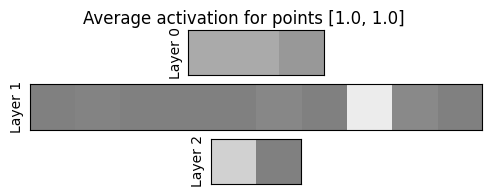

In [18]:
cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
cmap = ListedColormap(cmap)

# -- Display relevance --
for i in range(4):
    fig, axs = plt.subplots(L+1, 1)
    b = 3
    for l in range(L+1):
        relevance = np.mean(R[l][i::4], axis=0)

        axs[l].imshow(relevance.reshape((1, len(relevance))), cmap=cmap, interpolation='nearest', vmin=-b,vmax=b)
        axs[l].figure.set_size_inches(10, 2)
        print(f"    [Layer {l}] R: {relevance}")
        axs[l].set_xticks([])
        axs[l].set_yticks([])
        axs[l].set_ylabel(f"Layer {l}")

    point = X[i].tolist()
    point.pop() # remove useless feature from display

    fig.suptitle(f"Average relevance for points {point}")
    plt.show()

    # -- Display activations --
    fig, axs = plt.subplots(L+1, 1)
    b = 3
    for l in range(L+1):
        activation = np.mean(A[l][i::4], axis=0)

        axs[l].imshow(activation.reshape((1, len(activation))), cmap="gray", interpolation='nearest', vmin=-b,vmax=b)
        axs[l].figure.set_size_inches(10, 2)
        print(f"    [Layer {l}] A: {activation}")
        axs[l].set_xticks([])
        axs[l].set_yticks([])
        axs[l].set_ylabel(f"Layer {l}")

    fig.suptitle(f"Average activation for points {point}")
    plt.show()